In [2]:
# importing and installing

!pip install sqlalchemy
!pip install pyodbc

In [130]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


In [131]:
# Creating an engine and connecting
engine = create_engine('mssql://LAPTOP-3PE096A5/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()

In [132]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [133]:
connection = engine.connect()

In [134]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [135]:
# Inspecting the database

inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)


['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [136]:
for schema in schemas:
    print(schema)

db_accessadmin
db_backupoperator
db_datareader
db_datawriter
db_ddladmin
db_denydatareader
db_denydatawriter
db_owner
db_securityadmin
dbo
guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys


In [137]:
for col in inspector.get_columns(table_name='Customer', schema='Sales'):
#     print(col)
    print(col['name'])

CustomerID
PersonID
StoreID
TerritoryID
AccountNumber
rowguid
ModifiedDate


In [138]:
# Querying database AdventureWorks2022. The goal is to check situation for giving recommendations for a marketing campaign.

In [139]:
# Total sales per year

SalesPerYear ="""
SELECT 
       YEAR(OrderDate) AS YEAR,
       ROUND((SUM(TotalDue)/1000000), 0) AS SALES
  FROM Sales.SalesOrderHeader
  Group BY YEAR(OrderDate)
  ORDER BY YEAR(OrderDate);
"""
SalesPerYear_df = pd.read_sql(sql=SalesPerYear, con=connection)

In [140]:
SalesPerYear_df.head()

,YEAR,SALES
0,2011,14.0
1,2012,38.0
2,2013,49.0
3,2014,22.0


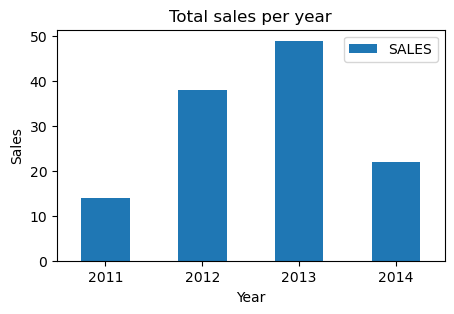

In [141]:
# Total sales per year - Plot

SalesPerYear_df = pd.read_sql(sql=SalesPerYear, con=connection)
SalesPerYear_df.set_index('YEAR').plot(kind='bar', figsize=(5, 3))
plt.xticks(rotation=0)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Total sales per year')
plt.show()


In [142]:
# Sales per category per year

SalesCategory ="""
SELECT FORMAT(soh.DueDate, 'yyyy-MM') AS Date
	, SUM(CASE WHEN ps.ProductCategoryID IN('1') THEN LineTotal END) / 1000000 AS Bikes
	, SUM(CASE WHEN ps.ProductCategoryID IN('2') THEN LineTotal END) / 1000000 AS Components
	, SUM(CASE WHEN ps.ProductCategoryID IN('3') THEN LineTotal END) / 1000000 AS Clothing
	, SUM(CASE WHEN ps.ProductCategoryID IN('4') THEN LineTotal END) / 1000000 AS Accessories
	
		
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY FORMAT(soh.DueDate, 'yyyy-MM')
ORDER BY 1;
"""
SalesPerYear_df = pd.read_sql(sql=SalesPerYear, con=connection)



In [143]:
SalesCategory_df = pd.read_sql(sql=SalesCategory, con=connection)

In [144]:
SalesCategory_df.head(10)

,Date,Bikes,Components,Clothing,Accessories
0,2011-06,0.713165,0.031525,0.002875,0.001695
1,2011-07,1.914435,0.114523,0.007038,0.003593
2,2011-08,1.569914,0.102512,0.005138,0.003250
3,2011-09,1.301344,0.061804,0.003583,0.001937
4,2011-10,2.692327,0.157234,0.008551,0.005490
5,2011-11,2.191138,0.147873,0.007188,0.004267
6,2011-12,1.335521,0.023698,0.001655,0.000585
7,2012-01,2.414248,0.078721,0.005533,0.002159
8,2012-02,1.970749,0.072624,0.004514,0.002200
9,2012-03,1.468700,0.063623,0.003652,0.001776


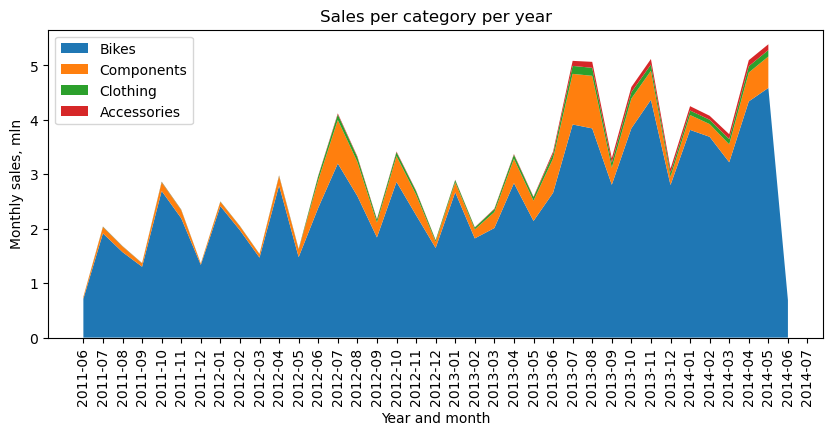

In [145]:
# Sales per category per year - plot

SalesCategory_df = pd.read_sql(sql=SalesCategory, con=connection)
x = SalesCategory_df['Date']
y1 = SalesCategory_df['Bikes'] 
y2 = SalesCategory_df['Components']
y3 = SalesCategory_df['Clothing']
y4 = SalesCategory_df['Accessories']
  
y = np.vstack([y1, y2, y3, y4]) 
  
labels = ["Bikes", "Components", "Clothing", "Accessories"] 
fig, ax = plt.subplots(figsize=(10, 4)) 

ax.stackplot(x, y1, y2, y3, y4, 
             labels = labels) 
ax.legend(loc ='upper left') 
ax.set_title('Sales per category per year') 

plt.xticks(rotation=90)

plt.xlabel('Year and month')
plt.ylabel('Monthly sales, mln')
plt.show() 


In [146]:
# Sales per subcategory for Bikes

SalesSubcategory_df = pd.read_sql(sql=SalesSubcategory, con=connection)

SalesSubcategory ="""
SELECT FORMAT(SOH.DueDate, 'yyyy-MM') AS Date

    , SUM(CASE WHEN PCS.ProductSubcategoryID IN('1') THEN LineTotal END) / 1000000 AS [Mountain Bikes]
	, SUM(CASE WHEN PCS.ProductSubcategoryID IN('2') THEN LineTotal END) / 1000000 AS [Road Bikes]
	, SUM(CASE WHEN PCS.ProductSubcategoryID IN('3') THEN LineTotal END) / 1000000 AS [Touring Bikes]
		  
FROM 
     Production.Product AS PR
INNER JOIN Sales.SalesOrderDetail AS SOD
	ON PR.ProductID = SOD.ProductID
INNER JOIN Sales.SalesOrderHeader AS SOH
	ON SOD.SalesOrderID = SOH.SalesOrderID
INNER JOIN Production.ProductSubcategory AS PCS
	ON PR.ProductSubcategoryID = PCS.ProductSubcategoryID

	WHERE PCS.ProductCategoryID = 1 	
	
	GROUP BY  FORMAT(soh.DueDate, 'yyyy-MM')
	ORDER BY 1
	;
"""

In [147]:
SalesSubcategory_df.head(10)

,Date,Mountain Bikes,Road Bikes,Touring Bikes
0,2011-06,0.284964,0.428200,NaN
1,2011-07,1.092386,0.822049,NaN
2,2011-08,0.842299,0.727614,NaN
3,2011-09,0.459168,0.842176,NaN
4,2011-10,1.370888,1.321439,NaN
5,2011-11,1.041002,1.150135,NaN
6,2011-12,0.464028,0.871493,NaN
7,2012-01,1.103446,1.310801,NaN
8,2012-02,0.930042,1.040707,NaN
9,2012-03,0.524238,0.944461,NaN


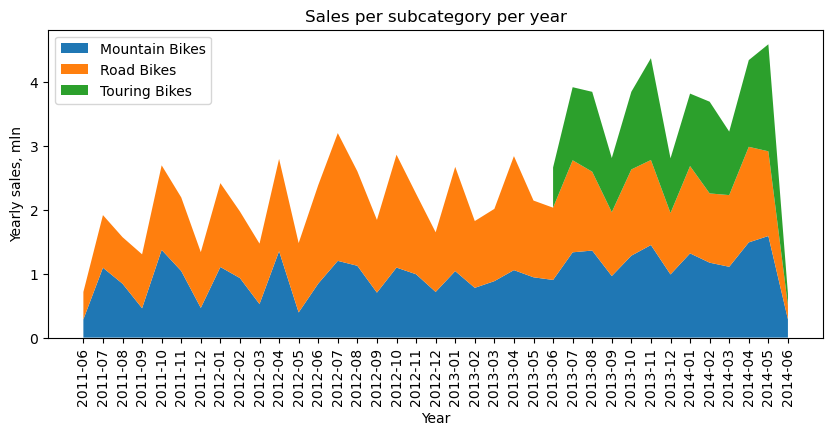

In [192]:
# Sales per subcategory for Bikes

SalesSubcategory_df = pd.read_sql(sql=SalesSubcategory, con=connection)

x = SalesSubcategory_df['Date']
y1 = SalesSubcategory_df['Mountain Bikes'] 
y2 = SalesSubcategory_df['Road Bikes']
y3 = SalesSubcategory_df['Touring Bikes']
  
y = np.vstack([y1, y2, y3]) 
  
labels = ["Mountain Bikes", "Road Bikes", "Touring Bikes"] 


fig, ax = plt.subplots(figsize=(10, 4)) 

ax.stackplot(x, y1, y2, y3, 
             labels = labels) 
  
ax.legend(loc ='upper left') 
ax.set_title('Sales per subcategory per year') 


plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Yearly sales, mln')
plt.show() 

In [193]:
#Sales per territory for Bikes in 2014

Territory ="""
SELECT 
	ST.Name
    , SUM(CASE WHEN PCS.ProductSubcategoryID IN('1') THEN LineTotal END) / 1000000 AS [Mountain Bikes]
	, SUM(CASE WHEN PCS.ProductSubcategoryID IN('2') THEN LineTotal END) / 1000000 AS [Road Bikes]
	, SUM(CASE WHEN PCS.ProductSubcategoryID IN('3') THEN LineTotal END) / 1000000 AS [Touring Bikes]
		  
FROM 
       Production.Product AS PR
       INNER JOIN Sales.SalesOrderDetail AS SOD
	      ON PR.ProductID = SOD.ProductID
       INNER JOIN Sales.SalesOrderHeader AS SOH
	      ON SOD.SalesOrderID = SOH.SalesOrderID
	   INNER JOIN Sales.SalesTerritory AS ST
	      ON ST.TerritoryID = SOH.TerritoryID
	   INNER JOIN Production.ProductSubcategory AS PCS
	      ON PR.ProductSubcategoryID = PCS.ProductSubcategoryID
		  		   
	WHERE PCS.ProductCategoryID = 1 AND YEAR(soh.DueDate)= 2014
	
	GROUP BY  ST.Name
	ORDER BY [Mountain Bikes] DESC, [Road Bikes], [Touring Bikes] 
	;

;
"""
Territory_df = pd.read_sql(sql=Territory, con=connection)


In [150]:
print (Territory_df)

             Name  Mountain Bikes  Road Bikes  Touring Bikes
0       Southwest        1.492211    1.525990       1.047224
1       Northwest        1.276423    0.681454       1.078256
2          Canada        0.889391    0.684498       0.667165
3  United Kingdom        0.705636    0.632127       0.707127
4       Australia        0.699431    0.956819       1.130205
5          France        0.569585    0.580584       0.737922
6         Germany        0.530303    0.339689       0.718375
7         Central        0.436721    0.435126       0.160544
8       Southeast        0.232763    0.399611       0.274473
9       Northeast        0.123250    0.366725       0.249415


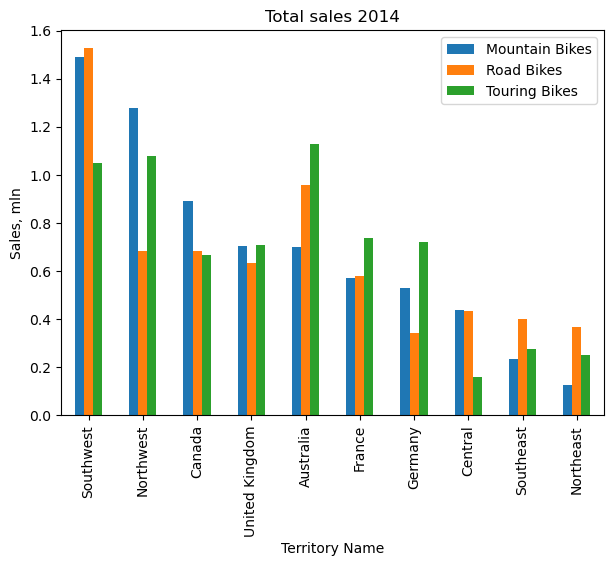

In [151]:
Territory_df = pd.read_sql(sql=Territory, con=connection)

Territory_df.set_index('Name').plot(kind='bar', figsize=(7, 5))
plt.xticks(rotation=0)
plt.xlabel('Territory Name')
plt.ylabel('Sales, mln')
plt.title('Total sales 2014')
plt.xticks(rotation=90)
plt.show()


In [194]:
# Accessories in the same order with Bikes in Australia

Australia ="""
SELECT 
DISTINCT SOD.SalesOrderID,
CASE WHEN PCS.ProductCategoryID = 4 THEN 1 ELSE 0 END AS Accessories		  
  FROM 
       Production.Product AS PR
       INNER JOIN Sales.SalesOrderDetail AS SOD
	      ON PR.ProductID = SOD.ProductID
       INNER JOIN Sales.SalesOrderHeader AS SOH
	      ON SOD.SalesOrderID = SOH.SalesOrderID
	   INNER JOIN Sales.SalesTerritory AS ST
	      ON ST.TerritoryID = SOH.TerritoryID
	   INNER JOIN Production.ProductSubcategory AS PCS
	      ON PR.ProductSubcategoryID = PCS.ProductSubcategoryID
  		   
  WHERE ST.Name = 'Australia' 
	  AND SOD.SalesOrderID IN
	       (
		   SELECT DISTINCT SOD.SalesOrderID
			FROM
			 Production.Product AS PR
             INNER JOIN Sales.SalesOrderDetail AS SOD
	         ON PR.ProductID = SOD.ProductID
             INNER JOIN Sales.SalesOrderHeader AS SOH
	         ON SOD.SalesOrderID = SOH.SalesOrderID
	         INNER JOIN Production.ProductSubcategory AS PCS
	         ON PR.ProductSubcategoryID = PCS.ProductSubcategoryID
		    WHERE PCS.ProductCategoryID IN (1)
	  	   )
	AND PCS.ProductCategoryID NOT IN (2,3) 
GROUP BY sod.SalesOrderID, OrderDate, PCS.ProductCategoryID
ORDER BY Accessories DESC, sod.SalesOrderID	  
;

"""
Australia_df = pd.read_sql(sql=Australia, con=connection)

In [195]:
print (Australia_df)

      SalesOrderID  Accessories
0            51176            1
1            51177            1
2            51189            1
3            51195            1
4            51196            1
...            ...          ...
6396         74137            0
6397         74139            0
6398         74145            0
6399         74146            0
6400         74147            0

[6401 rows x 2 columns]


In [196]:
FRQ_df = pd.read_sql(sql=Australia, con=connection)
FRQ = FRQ_df.Accessories

CONF = stats.norm.interval(0.95, loc=np.mean(FRQ), scale=stats.sem(FRQ))

print(f"Average frequency for Accessories in the same order as Bike in the orders from Australia: {np.mean(FRQ)}") 

print(f"Confidence interval for average frequency for Accessories in the same order as Bikes in the orders from Australia:{CONF}")

Average frequency for Accessories in the same order as Bike in the orders from Australia: 0.285267926886424
Confidence interval for average frequency for Accessories in the same order as Bikes in the orders from Australia:(0.2742053522795285, 0.29633050149331946)
